In [1]:
import time
import copy
import tqdm
import control
import numpy as np
import scipy as sp
import scipy.special as ssp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('ticks')
rgblist = sns.color_palette('tab10')

In [2]:
import torch
from torch import nn
import torch.optim as optim

In [3]:
class Cont_riverswim():
    def __init__(self):
        self.d_A = 1
        self.d_S = 1
        
        self.state_space = ([0 for i in range(self.d_S)], [6 for i in range(self.d_S)])
        self.action_space = ([-1 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.zeros((self.d_S))
        return self.state
    
    def step(self, action):
        direction = np.random.choice([-1,0,1], p=[0.4*(1-action[0]), 0.2, 0.4*(1 + action[0])])
        self.state = np.array([min(6,max(0,self.state[0] + direction*0.5*(1 + 0.5*np.random.normal())))])
        self.reward = self.get_reward(np.concatenate((self.state, action)))
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[0]
        a = sa[1]
        return (1/2592)*(0.01*((s-6)**4) + s**4) + (1/32)*(0.01*((a-1)**4) + (a+1)**4)

class LinSys2x2():
    def __init__(self):
        self.d_A = 2
        self.d_S = 2
        
        self.state_space = ([-4 for i in range(self.d_S)], [4 for i in range(self.d_S)])
        self.action_space = ([-1 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.A = np.array([[-0.2, -0.07], [0.6, 0.07]])
        self.B = np.array([[0.07, 0.09], [-0.03, -0.1]])
        
        self.P = 0.4*np.eye(2)
        self.Q = 0.6*np.eye(2)
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.random.uniform(-1,1,size=2)
        return self.state
    
    def step(self, action):
        self.state = np.clip(np.matmul(self.A, self.state) + np.matmul(self.B, action) + 0.05*np.random.normal(size=2), 
                             self.state_space[0], self.state_space[1])
        
        self.reward = self.get_reward(np.concatenate((self.state,action)))
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[:self.d_S]
        a = sa[self.d_S:]
        return - np.dot(s,np.matmul(self.P,s)) - np.dot(a,np.matmul(self.Q,a))

class NonLinSys2x2():
    def __init__(self):
        self.d_A = 2
        self.d_S = 2
        
        self.state_space = ([-4 for i in range(self.d_S)], [4 for i in range(self.d_S)])
        self.action_space = ([-1 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.A = np.array([[-0.2, -0.07], [0.6, 0.07]])
        self.B = np.array([[0.07, 0.09], [-0.03, -0.1]])
        
        self.P = 0.4*np.eye(2)
        self.Q = 0.6*np.eye(2)
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.random.uniform(-1,1,size=2)
        return self.state
    
    def step(self, action):
        self.state = np.clip(np.matmul(self.A, 0.5*self.state + 0.5*np.square(self.state)) + np.matmul(self.B, np.square(action))
                             + 0.05*np.random.normal(size=2), self.state_space[0], self.state_space[1])
        
        self.reward = self.get_reward(np.concatenate((self.state,action)))
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[:self.d_S]
        a = sa[self.d_S:]
        return - np.dot(s,np.matmul(self.P,s)) - np.dot(a,np.matmul(self.Q,a))

class LinSys2x4():
    def __init__(self):
        self.d_A = 4
        self.d_S = 2
        
        self.state_space = ([-4 for i in range(self.d_S)], [4 for i in range(self.d_S)])
        self.action_space = ([-1 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.A = np.array([[-0.2, -0.07], [0.6, 0.07]])
        self.B = np.array([[0.1, -0.01, 0.12, 0.08], [0.02, -0.1, 0.3, 0.001]])
        
        self.P = 0.4*np.eye(2)
        self.Q = 0.6*np.eye(4)
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.random.uniform(-1,1,size=2)
        return self.state
    
    def step(self, action):
        self.state = np.clip(self.A.dot(self.state) + self.B.dot(action) + 0.05*np.random.normal(size=2), 
                             self.state_space[0], self.state_space[1])
        
        self.reward = self.get_reward(np.concatenate((self.state,action)))
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[:self.d_S]
        a = sa[self.d_S:]
        return - np.dot(s,np.matmul(self.P,s)) - np.dot(a,np.matmul(self.Q,a))

class Cont_gridworld():
    def __init__(self):
        self.d_A = 1
        self.d_S = 2
        
        self.state_space = ([0 for i in range(self.d_S)], [1 for i in range(self.d_S)])
        self.action_space = ([0 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
        self.step_size = 0.1
        self.reward_center = np.array([0.8, 0.8])
        self.reward_radii = 0.08
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.zeros((self.d_S))
        return self.state
    
    def step(self, action):
        theta = 2*np.pi*action[0] + np.random.normal(0,0.1)
        self.state = np.clip(self.state + self.step_size*np.array([np.cos(theta), np.sin(theta)]) 
                             + np.random.normal(0,0.1,2), 0, 1)
        
        if np.linalg.norm(self.state - self.reward_center) <= self.reward_radii:
            self.reward = 1
        else:
            self.reward = 0
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[0]
        a = sa[1]
        return (1/2592)*(0.01*((s-6)**4) + s**4) + (1/32)*(0.01*((a-1)**4) + (a+1)**4)

In [4]:
class Cell:
    def __init__(self, start, end, d_S=2, factor=1, parent=None, part_scheme='adapt'):
        self.d = len(start)
        self.d_S = d_S
        self.start = start
        self.end = end
        self.center = [0.5*(start[i]+end[i]) for i in range(self.d)]
        self.factor = factor
        self.diam = (end[0] - start[0])/factor
        self.parent = parent
        self.children = None
        self.part_scheme = part_scheme
        
        if self.part_scheme == 'adapt':
            self.active = True
            if parent is not None:
                for s_child in parent.s_proj.children:
                    if np.equal(self.start[:d_S], s_child.start).all() and np.equal(self.end[:d_S], s_child.end).all():
                        self.s_proj = s_child
                        break
                self.visits = self.parent.visits
                self.visit_times = self.parent.visit_times.copy()
            else:
                self.s_proj = State_cell(self.start, self.end, d_S, part_scheme=part_scheme)
                self.visits = 0
                self.visit_times = []
            self.add_self(self.s_proj)
            
        else:
            self.visits = 0
    
    def remove_self(self, proj):
        for child in proj.children:
            child.corresp_cells.remove(self)
            if child.children is not None:
                self.remove_self(child)
    
    def add_self(self, proj):
        proj.corresp_cells.append(self)
        if proj.children is not None:
            for child in proj.children:
                self.add_self(child)
                
    def get_children(self):
        if self.part_scheme == 'adapt':
            self.active = False
            if self.s_proj.children is None:
                self.s_proj.get_children()
            self.remove_self(self.s_proj)
        
        cells = [[] for i in range(self.d)]
        self.children = []
        for i in range(self.d):
            cells[i].append([self.start[i], self.center[i]])
            cells[i].append([self.center[i], self.end[i]])
        for j in range(2**self.d):
            M = []
            m = bin(j)[2:]
            l_m = len(m)
            if l_m < self.d:
                for l in range(self.d-l_m):
                    m = '0'+m
            for k in range(self.d):
                M.append(int(m[k:k+1]))
            ch = [cells[i][M[i]] for i in range(self.d)]
            start = [ch[i][0] for i in range(self.d)]
            end = [ch[i][1] for i in range(self.d)]
            self.children.append(Cell(start, end, d_S=self.d_S, factor=self.factor, parent=self, part_scheme=self.part_scheme))


In [5]:
class State_cell:
    def __init__(self, start, end, d_S=2, parent=None, part_scheme='adapt'):
        self.d_S = d_S
        self.start = start[:d_S]
        self.end = end[:d_S]
        self.center = [0.5*(self.start[i]+self.end[i]) for i in range(self.d_S)]
        self.children = None
        self.parent = parent
        self.part_scheme = part_scheme
        self.corresp_cells = []
        if self.part_scheme == 'adapt' and parent is not None:
            self.corresp_cells = parent.corresp_cells.copy()
        else:
            self.visits = 0
        
    def get_children(self):
        cells = [[] for i in range(self.d_S)]
        self.children = []
        for i in range(self.d_S):
            cells[i].append([self.start[i], self.center[i]])
            cells[i].append([self.center[i], self.end[i]])
        for j in range(2**self.d_S):
            M = []
            m = bin(j)[2:]
            l_m = len(m)
            if l_m < self.d_S:
                for l in range(self.d_S-l_m):
                    m = '0'+m
            for k in range(self.d_S):
                M.append(int(m[k:k+1]))
            ch = [cells[i][M[i]] for i in range(self.d_S)]
            child = {}
            start = [ch[i][0] for i in range(self.d_S)]
            end = [ch[i][1] for i in range(self.d_S)]
            self.children.append(State_cell(start, end, self.d_S, parent=self, part_scheme=self.part_scheme))

In [6]:
def find_cell(point, cells):
    d = len(point)
    for cell in cells:
        skip = False
        for i in range(d):
            if cell.start[i] > point[i] or cell.end[i] < point[i]:
                skip = True
                break
        if skip == False:
            return cell
    return None

In [7]:
def get_eps_cover(eps, env):
    d_S = env.d_S
    d_A = env.d_A
    d = d_S + d_A
    eps_cover = [Cell(env.state_space[0]+env.action_space[0],
                      env.state_space[1]+env.action_space[1],
                      d_S=d_S, factor=env.scaling_factor, part_scheme='fxd'),]
    eps_state_cover = [State_cell(eps_cover[0].start, eps_cover[0].end, d_S=d_S, part_scheme='fxd'),]
    l = np.ceil(np.log2(1/eps)).astype(np.int32)
    covers = [eps_cover,]
    state_covers = [eps_state_cover,]
    for i in range(l):
        state_covers.append([])
        covers.append([])
        for state_cell in state_covers[i]:
            state_cell.get_children()
            state_covers[i+1] = state_covers[i+1] + state_cell.children
        for cell in covers[i]:
            cell.get_children()
            covers[i+1] = covers[i+1] + cell.children
    
    eps_cover = covers[-1]
    eps_state_cover = state_covers[-1]
    
    for cell in eps_cover:
        for s_cell in eps_state_cover:
            if np.equal(cell.start[:d_S], s_cell.start).all() and np.equal(cell.end[:d_S], s_cell.end).all():
                s_cell.corresp_cells.append(cell)
                continue
    return eps_cover, eps_state_cover

In [8]:
def value_iteration(p, r, cover, state_cover):
    V = {}
    for s_cell in state_cover:
        V[s_cell] = 0
    policy = {}
    k = state_cover[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_cover:
            Q = {}
            for cell in s_cell.corresp_cells:
                Q[cell] = r[cell] + sum(p[cell][s_nxt_cell]*V_old[s_nxt_cell] for s_nxt_cell in state_cover)
            V[s_cell] = max(Q.values())
            policy[s_cell] = max(Q, key=Q.get)
        if np.max(abs(np.array(list(V.values())) - np.array(list(V_old.values())))) - np.min(abs(np.array(list(V.values())) - np.array(list(V_old.values())))) < 1e-6:
            break
    return policy, V[k]/count

In [9]:
def evi(p, r, active_cover, state_partition, tol=0.1, conf_coef=10):
    V = {}
    for s_cell in state_partition:
        V[s_cell] = 0
    policy = {}
    k = state_partition[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_partition:
            Q = {}
            for cell in s_cell.corresp_cells:
                conf_rad = conf_coef/max(1,(cell.visits)**(1/(s_cell.d_S+2)))
                Q[cell] = r[cell] + inner_max(p[cell], V_old, conf_rad, state_partition)
            V[s_cell] = max(Q.values())
            policy[s_cell] = max(Q, key=Q.get)
        delta_V = np.array(list(V.values())) - np.array(list(V_old.values()))
        if np.max(delta_V) - np.min(delta_V) < tol:
            break
    return policy

def epe(p, r, state_partition, phi_partition, tol=0.1, conf_coef=10):
    s_lst = state_partition[-1]
    V = {}
    for s_cell in state_partition:
        V[s_cell] = 0
    policy = {}
    k = state_partition[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_partition:
            cell = phi_partition[s_cell]
            conf_rad = conf_coef/max(1,np.sqrt(cell.visits))
            V[s_cell] = r[cell] + inner_max(p[cell], V_old, conf_rad, state_partition)
        if (np.max(abs(np.array(list(V.values())) - np.array(list(V_old.values()))))
        - np.min(abs(np.array(list(V.values())) - np.array(list(V_old.values()))))) < tol*(abs(V[s_lst] - V_old[s_lst])):
            break
    return abs(V[s_lst] - V_old[s_lst])


def inner_max(p, V, conf_rad, state_partition):
    V_sort = dict(sorted(V.items(), key=lambda item: item[1]))
    
    p_ = p.copy()
    
    remain_conf_rad = 0.5*conf_rad
    for s_cell in list(V_sort.keys())[::-1]:
        p_[s_cell] = min(1, p[s_cell] + remain_conf_rad)
        remain_conf_rad -= p_[s_cell] - p[s_cell]
        if remain_conf_rad == 0:
            break
    
    for s_cell in list(V_sort.keys()):
        p_[s_cell] = max(0, 1 - sum(p_.values()) + p_[s_cell])
        if sum(p_.values(), 0.0) == 1:
            break
    
    maximized_expt_reward = 0
    for s_cell in state_partition:
        maximized_expt_reward += p_[s_cell]*V[s_cell]
    
    return maximized_expt_reward

In [10]:
def update_partition(point, C, time, partition, s_partition, eps=0):
    update_flag = False
    update_s_part = False
    cur_cell = find_cell(point,partition)
    if cur_cell is None:
        print(point)
    cur_cell.visits += 1
    cur_cell.visit_times.append(time)
    if cur_cell.visits > C*(cur_cell.diam**(-(d_S+2))) and cur_cell.diam >= eps:
        update_flag = True
        cur_cell.get_children()
        partition = partition + cur_cell.children
        partition.remove(cur_cell)
        if cur_cell.s_proj in s_partition:
            s_partition.remove(cur_cell.s_proj)
            s_partition = s_partition + cur_cell.s_proj.children
            update_s_part = True
    
    return cur_cell, partition, s_partition, update_flag, update_s_part

In [11]:
def zorl(env, T, hyperparams, seed, verbose=False):
    C_a = hyperparams[0]                                  # cell activation coefficient
    L_r = hyperparams[1]                                  # bonus coefficient
    C_c = hyperparams[2]                                  # confidence coefficient
    C_H = hyperparams[3]                                  # episode duration parameter
    eps_bd = hyperparams[4]                               # base discretization parameter
    gamma = 0.05
    delta = 0.1
    
    
    active_cover = [Cell(env.state_space[0]+env.action_space[0], 
                         env.state_space[1]+env.action_space[1],
                         d_S=env.d_S, factor=env.scaling_factor, part_scheme='adapt'),]
    
    state_partition = [active_cover[0].s_proj,]
    
    # The next block will be executed
    max_diam = 1
    now = time.time()
    while max_diam > eps_bd:
        diams = {}
        for cell in active_cover:
            diams[cell] = cell.diam
        max_diam = max(diams.values())
        for cell in active_cover:
            if diams[cell] > eps_bd:
                while cell.visits <= C_a*(cell.diam**(-(d_S+2))):
                    cell.visits += 1
                cell.get_children()
                active_cover = active_cover + cell.children
                active_cover.remove(cell)
                if cell.s_proj in state_partition:
                    state_partition.remove(cell.s_proj)
                    state_partition = state_partition + cell.s_proj.children
    visit_snap = {}
    for cell in active_cover:
        cell.visits = 0
        visit_snap[cell] = 1
    
    state_partition_k = state_partition.copy()
    transitions = []
    episode_start = False
    
    episode_count = 0
    
    sum_rewards = 0
    cumul_rewards = []
    
    h = 0
    
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if t == 0 or episode_start:
            h = 0
            episode_start = False
            episode_count += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(episode_count, t+1))
            state_partition_k = state_partition.copy()
            transition_counter = {}
            for cell in active_cover:
                transition_counter[cell] = {}
                for s_cell in state_partition:
                    transition_counter[cell][s_cell] = 0
            for cell in active_cover:
                if t-1 in cell.visit_times:
                    cell.visit_times.remove(t-1)
                for i in cell.visit_times:
                    next_cell = find_cell(transitions[i+1][:env.d_S],state_partition)
                    transition_counter[cell][next_cell] += 1
            p_hat = {}
            r_hat = {}
            d_hat = {}
            visit_snap = {}
            for cell in active_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                r_hat[cell] = env.get_reward(cell.center) + L_r*cell.diam
                d_hat[cell] = cell.diam
                visit_snap[cell] = max(1,cell.visits)
            start = time.time()
            policy = evi(p_hat, r_hat, active_cover, state_partition_k, 1/np.sqrt(max(1,t)), C_c)
            
            policy_cells = {}
            for st_cell in state_partition_k:
                st = st_cell.center
                acn = policy[st_cell].center[env.d_S:]
                stacn = np.concatenate((st, acn))
                cl = find_cell(stacn, active_cover)
                policy_cells[st_cell] = cl
            diam_pol = epe(p_hat, d_hat, state_partition_k, policy_cells, gamma, C_c)
            H = C_H*np.log(T)*(diam_pol**(-2*env.d_S - 2))
        h += 1
        
        state = next_state.copy()
        state_cell = find_cell(state, state_partition_k)
        action = policy[state_cell].center[env.d_S:]
        
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        transitions.append(sa)
        old_active_cover = active_cover.copy()
        sa_cell, active_cover, state_partition, _, _ = update_partition(sa, C_a, t, active_cover, state_partition)
        
        if h >= H: 
            episode_start = True
    return cumul_rewards

In [12]:
def zorl_eps(env, T, hyperparams, seed, verbose=False):
    C_a = hyperparams[0]                                  # cell activation coefficient
    L_r = hyperparams[1]                                  # bonus coefficient
    C_c = hyperparams[2]                                  # confidence coefficient
    C_H = hyperparams[3]                                  # episode duration parameter
    eps_bd = hyperparams[4]                               # base discretization parameter
    
    
    active_cover = [Cell(env.state_space[0]+env.action_space[0], 
                         env.state_space[1]+env.action_space[1],
                         d_S=env.d_S, factor=env.scaling_factor, part_scheme='adapt'),]
    
    state_partition = [active_cover[0].s_proj,]
    
    # The next block will be executed
    max_diam = 1
    now = time.time()
    while max_diam > eps_bd:
        diams = {}
        for cell in active_cover:
            diams[cell] = cell.diam
        max_diam = max(diams.values())
        for cell in active_cover:
            if diams[cell] > eps_bd:
                while cell.visits <= C_a*(cell.diam**(-(d_S+2))):
                    cell.visits += 1
                cell.get_children()
                active_cover = active_cover + cell.children
                active_cover.remove(cell)
                if cell.s_proj in state_partition:
                    state_partition.remove(cell.s_proj)
                    state_partition = state_partition + cell.s_proj.children
    visit_snap = {}
    for cell in active_cover:
        cell.visits = 0
        visit_snap[cell] = 1
    
    state_partition_k = state_partition.copy()
    transitions = []
    episode_start = False
    
    episode_count = 0
    
    sum_rewards = 0
    cumul_rewards = []
    
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if t == 0 or episode_start:
            h = 0
            episode_start = False
            episode_count += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(episode_count, t+1))
            state_partition_k = state_partition.copy()
            transition_counter = {}
            for cell in active_cover:
                transition_counter[cell] = {}
                for s_cell in state_partition:
                    transition_counter[cell][s_cell] = 0
            for cell in active_cover:
                if t-1 in cell.visit_times:
                    cell.visit_times.remove(t-1)
                for i in cell.visit_times:
                    next_cell = find_cell(transitions[i+1][:env.d_S],state_partition)
                    transition_counter[cell][next_cell] += 1
            p_hat = {}
            r_hat = {}
            visit_snap = {}
            for cell in active_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                r_hat[cell] = env.get_reward(cell.center) + L_r*cell.diam
                visit_snap[cell] = max(1,cell.visits)
            start = time.time()
            policy = evi(p_hat, r_hat, active_cover, state_partition_k, 1/np.sqrt(max(1,t)), C_c)
            
            diam_pol = sum([policy[s_cell].diam for s_cell in state_partition_k])/len(state_partition_k)
            H = C_H*np.log(T)*(diam_pol**(-2*env.d_S - 2))
        h += 1
        
        state = next_state.copy()
        state_cell = find_cell(state, state_partition_k)
        action = policy[state_cell].center[env.d_S:]
        
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        transitions.append(sa)
        old_active_cover = active_cover.copy()
        
        sa_cell, active_cover, state_partition, update_flag, _ = update_partition(sa, C_a, t, active_cover, state_partition)
        if h >= H:
            episode_start = True
        
    return cumul_rewards

In [13]:
def pzrl(env, T, hyperparams, model, seed, verbose=False):
    C_a = hyperparams[0]                                # activation coefficient
    C_b = hyperparams[1]                                # bonus coefficient
    C_c = hyperparams[2]                                # confidence coefficient
    eps_bd = hyperparams[3]                             # base discretization parameter
    
    active_cover = [Cell(env.state_space[0]+env.action_space[0], 
                         env.state_space[1]+env.action_space[1],
                         d_S=env.d_S, factor=env.scaling_factor, part_scheme='adapt'),]
    
    state_partition = [active_cover[0].s_proj,]
    max_diam = 1
    now = time.time()
    while max_diam > eps_bd:
        diams = {}
        for cell in active_cover:
            diams[cell] = cell.diam
        max_diam = max(diams.values())
        for cell in active_cover:
            if diams[cell] > eps:
                while cell.visits <= C_a*(cell.diam**(-(d_S+2))):
                    cell.visits += 1
                cell.get_children()
                active_cover = active_cover + cell.children
                active_cover.remove(cell)
                if cell.s_proj in state_partition:
                    state_partition.remove(cell.s_proj)
                    state_partition = state_partition + cell.s_proj.children
    visit_snap = {}
    for cell in active_cover:
        cell.visits = 0
        visit_snap[cell] = 1
    
    optim_grid_eps = 0.3
    _, eps_state_cover = get_eps_cover(optim_grid_eps, env)
    data_pts = []
    for s_cell in eps_state_cover:
        data_pts.append(s_cell.center)
    X = torch.tensor(data_pts, dtype=torch.float32)
    loss_fn = nn.MSELoss()  # mean square error
    
    n_epochs = 1000   # number of epochs to run

    state_partition_k = state_partition.copy()
    transitions = []
    episode_start = False
    h = 0
    policy = {}
    policy[state_partition[0]] = active_cover[0]
    episode_count = 0
    cumul_rewards = []
    sum_rewards = 0
    conf_coef = 5
    
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if t != 0 and episode_start:
            h = 0
            episode_start = False
            episode_count += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(episode_count, t+1))
            state_partition_k = state_partition.copy()
            transition_counter = {}
            for cell in active_cover:
                transition_counter[cell] = {}
                for s_cell in state_partition:
                    transition_counter[cell][s_cell] = 0
            for cell in active_cover:
                if t-1 in cell.visit_times:
                    cell.visit_times.remove(t-1)
                for i in cell.visit_times:
                    next_cell = find_cell(transitions[i+1][:env.d_S],state_partition)
                    transition_counter[cell][next_cell] += 1
            p_hat = {}
            r_hat = {}
            visit_snap = {}
            for cell in active_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                r_hat[cell] = env.get_reward(cell.center) + C_b*cell.diam
                visit_snap[cell] = max(1,cell.visits)
            policy = evi(p_hat, r_hat, active_cover, state_partition, 1/np.sqrt(max(1,t)), C_c)
            labels = []
            for pt in data_pts:
                pt_s_cell = find_cell(pt, state_partition_k)
                labels.append(policy[pt_s_cell].center[env.d_S:])
            best_l = np.inf   # init to infinity
            best_weights = None
            history = []
            y = torch.tensor(labels, dtype=torch.float32)
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
            for epoch in range(n_epochs):
                model.train()
                # forward pass
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # evaluate accuracy at end of each epoch
                l = float(loss)
                history.append(loss)
                if l < best_l:
                    best_l = l
                    best_weights = copy.deepcopy(model.state_dict())
            # restore model and return best accuracy
            model.load_state_dict(best_weights)
        h += 1
        state = next_state.copy()
        state_cell = find_cell(state, state_partition_k)
        action = np.clip(model(torch.tensor(state).float()).detach().numpy(), 
                         env.action_space[0][0], env.action_space[1][0])
        
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        transitions.append(sa)
        old_active_cover = active_cover.copy()
        sa_cell, active_cover, state_partition, update_flag, update_s_part = update_partition(sa, C_a, t, active_cover, state_partition)
        
        if update_flag: 
            episode_start = True
        elif sa_cell.visits >= (2**(env.d_S))*visit_snap[sa_cell]:
            episode_start = True
    return cumul_rewards

In [14]:
def ucrl2(env, T, eps, C_c, seed, verbose=False):
    eps_cover, eps_state_cover = get_eps_cover(eps, env)
    transition_counter, visit_snap = {}, {}
    r_hat = {}
    for cell in eps_cover:
        cell.visits = 0
        visit_snap[cell] = 1
        transition_counter[cell] = {}
        r_hat[cell] = env.get_reward(cell.center)
        for s_cell in eps_state_cover:
            transition_counter[cell][s_cell] = 0
    episode_start = False

    H = np.ceil(np.sqrt(T)).astype(np.int32)
    h = 0
    policy = {}
    for s_cell in eps_state_cover:
        policy[s_cell] = np.random.choice(s_cell.corresp_cells)
    episode_count = 0
    cumul_rewards = []
    sum_rewards = 0

    np.random.seed(seed)
    next_state = env.init()
    s_nxt_cell = find_cell(next_state, eps_state_cover)
    for t in range(T):
        if t != 0 and episode_start:
            episode_count += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(episode_count, t+1))
            episode_start = False
            h = 0
            p_hat = {}
            for cell in eps_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                visit_snap[cell] = max(1,cell.visits)
            policy = evi(p_hat, r_hat, eps_cover, eps_state_cover, t, C_c)
        h += 1
        state = next_state.copy()
        s_cell = s_nxt_cell
        action = policy[s_cell].center[env.d_S:]
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        sa_cell = find_cell(sa, eps_cover)
        sa_cell.visits += 1
        s_nxt_cell = find_cell(next_state, eps_state_cover)
        transition_counter[sa_cell][s_nxt_cell] += 1
        if sa_cell.visits >= (2**env.d_S)*visit_snap[sa_cell]:
            episode_start = True
    del eps_cover, eps_state_cover
    return cumul_rewards

In [15]:
def rvi_q(env, T, eps, seed, verbose=False):
    eps_cover, eps_state_cover = get_eps_cover(eps, env)
    xplr_0 = np.log(T)/2
    transition_counter, transition_counter_snap = {}, {}
    q = {}
    for cell in eps_cover:
        q[cell] = 0
    
    cumul_rewards = []
    sum_rewards = 0

    np.random.seed(seed)
    next_state = env.init()
    s_nxt_cell = find_cell(next_state, eps_state_cover)
    s_nxt_cell.visits += 1
    canditates = {cell: q[cell] for cell in s_nxt_cell.corresp_cells}
    for t in range(T):
        state = next_state.copy()
        s_cell = s_nxt_cell
        xplr = min(xplr_0/np.sqrt(s_cell.visits+1),1)
        ind = np.random.choice([0,1], p=[1-xplr,xplr])
        if ind == 1:
            action = np.random.uniform(0,1,size=env.d_A)
        else:
            best_cell = max(candidates, key=candidates.get)
            action = best_cell.center[env.d_S:]
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        sa_cell = find_cell(sa, eps_cover)
        sa_cell.visits += 1
        s_nxt_cell = find_cell(next_state, eps_state_cover)
        s_nxt_cell.visits += 1
        candidates = {cell: q[cell] for cell in s_nxt_cell.corresp_cells}
        q[sa_cell] += (1/np.sqrt(sa_cell.visits+1))*(reward + max(candidates.values()) - q[sa_cell] - q[eps_cover[0]])
    del eps_cover, eps_state_cover
    return cumul_rewards

In [16]:
def drchrnd(alpha, eps_cover):
    """
    Generates a sample from drichlet distribution with parameters alpha
    alpha - (n_s, n_a, n_s)
    """
    P = {}
    for cell in eps_cover:
        P[cell] = {}
        p = np.random.dirichlet(list(alpha[cell].values()))
        for i, s_cell in enumerate(alpha[cell].keys()):
            P[cell][s_cell] = p[i]
    
    return P

In [17]:
def tsde(env, T, eps, seed, verbose=False):
    eps_cover, eps_state_cover = get_eps_cover(eps, env)
    
    rewards = []
    
    rho, rho_base = {}, {}
    alpha, alpha_snap = {}, {}
    r_hat = {}
    for cell in eps_cover:
        alpha[cell] = {}
        alpha_snap[cell] = {}
        rho[cell] = 0
        rho_base[cell] = 1
        r_hat[cell] = env.get_reward(cell.center)
        for s_cell in eps_state_cover:
            alpha[cell][s_cell] = 0.1
            alpha_snap[cell][s_cell] = 0.1
    
    episode = 1
    task_episode = 1
    t_last = 0      # t_last - Last sampling time
    T_last = 0      # T_last - Last episode length
    
    sum_rewards = 0
    task_stage = 0
    h = 0
    visit_double_flag = False
    np.random.seed(seed)
    
    next_state = env.init()
    s_nxt_cell = find_cell(next_state, eps_state_cover)
    s_nxt_cell.visits += 1
    
    for t in range(T):
        if t==0 or (visit_double_flag and t-t_last >= T_last + 1):
            h = 0
            visit_double_flag = False
            if verbose:
                print("Episode: {} | Stage: {}".format(episode,t+1))
            theta = drchrnd(alpha, eps_cover)
            policy, _ = value_iteration(theta, r_hat, eps_cover, eps_state_cover)
            T_last = t-t_last
            t_last = t
            for cell in eps_cover:
                rho_base[cell] = copy.deepcopy(rho[cell])
            episode += 1
        
        task_stage += 1
        h += 1
        state = next_state.copy()
        s_cell = s_nxt_cell
        action = policy[s_cell].center[d_S:]
        # execute the action
        next_state, reward = env.step(action)
        
        sum_rewards += reward
        rewards.append(sum_rewards)
        
        sa = np.concatenate((state, action))
        sa_cell = find_cell(sa, eps_cover)
        sa_cell.visits += 1
        
        s_nxt_cell = find_cell(next_state, eps_state_cover)
        s_nxt_cell.visits += 1
        
        alpha[sa_cell][s_nxt_cell] += 1
        rho[sa_cell] += 1
        
        state = copy.deepcopy(next_state)
        
        if not visit_double_flag:
            visit_double_flag = sa_cell.visits >= (2**env.d_S)*rho_base[sa_cell]
    return np.array(rewards)

In [18]:
expts = ['zorl', 'pzrl', 'ucrl2', 'tsde', 'rvi_q', 'zorl-e']
colors = {'ucrl2':rgblist[0],'rvi_q':rgblist[1],'zorl':rgblist[2],'tsde':rgblist[3], 'pzrl':rgblist[4],'zorl-e':rgblist[5],}
expt_names = {'ucrl2':'UCRL2','rvi_q':'RVI-Q','zorl':'ZoRL','tsde':'TSDE', 'pzrl':'PZRL-H','zorl-e':'ZoRL-$\epsilon$'}

Environment: Linear System of with m=2, n=2

In [19]:
M = LinSys2x2()
d_S = M.d_S
d_A = M.d_A
d = d_S + d_A
T = 4000

### Hyperparameters ###

## ZoRL ##
C_a = 0.2
L_r = 0.001
C_c = 1
C_H = 0.05
eps_bd = 1

zorl_hps = [C_a, L_r, C_c, C_H, eps_bd]

## ZoRL-eps ##
C_a = 0.2
L_r = 0.001
C_c = 1
C_H = 0.1
eps_bd = 1

zorl_e_hps = [C_a, L_r, C_c, C_H, eps_bd]

## PZRL ##
model = nn.Sequential(
    nn.Linear(M.d_S, 3),
    nn.ReLU(),
    nn.Linear(3, M.d_A)
)
C_a = 0.2
L_r = 0.001
C_c = 1
eps_bd = 1

pzrl_hps = [C_a, L_r, C_c, eps_bd]

eps = 0.25

In [20]:
repeats = 50
rewards_1 = {}
for expt in expts:
    rewards_1[expt] = np.zeros((repeats, T))

In [21]:
verbose = False
for run in range(repeats):
    print("Run: ", run+1, end='\r', flush=True)
    for expt in expts:
        start = time.time()
        if expt == 'ucrl2':
            rewards_1[expt][run] = ucrl2(M, T, eps, C_c, run, verbose)
        elif expt == 'zorl':
            rewards_1[expt][run] = zorl(M, T, zorl_hps, run, verbose)
        elif expt == 'zorl-e':
            rewards_1[expt][run] = zorl_eps(M, T, zorl_e_hps, run, verbose)
        elif expt == 'rvi_q':
            rewards_1[expt][run] = rvi_q(M, T, eps, run, verbose)
        elif expt == 'tsde':
            rewards_1[expt][run] = tsde(M, T, eps, run, verbose)
        elif expt == 'pzrl':
            rewards_1[expt][run] = pzrl(M, T, pzrl_hps, model, run, verbose)

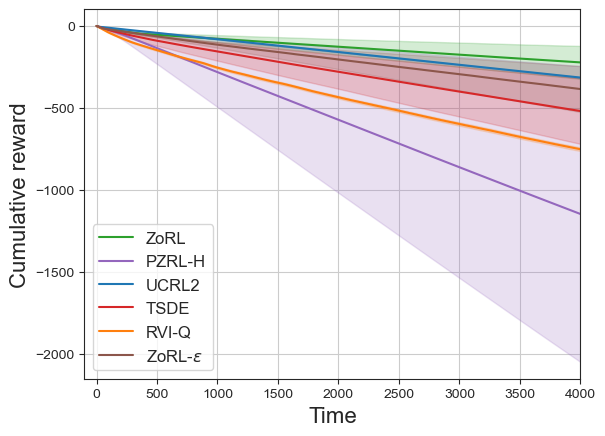

In [22]:
reward_mean_1, reward_std_1 = {}, {}
for expt in expts:
    reward_mean_1[expt] = np.mean(rewards_1[expt],axis=0)
    reward_std_1[expt] = np.std(rewards_1[expt],axis=0)
np.save('LinSys2x2_data.npy', [reward_mean_1, reward_std_1])

plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),reward_mean_1[expt], color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),reward_mean_1[expt]-reward_std_1[expt],
                     reward_mean_1[expt]+reward_std_1[expt], color=colors[expt],alpha=0.2)
    plt.legend(fontsize=12,loc='best')
plt.grid()
plt.xlabel('Time',fontsize=16)
plt.ylabel('Cumulative reward',fontsize=16)
plt.xlim(-100,T)
plt.savefig("LinSys2x2_cumul_reward.pdf")

Environment: Continuous RiverSwim

In [23]:
M = Cont_riverswim()
d_S = M.d_S
d_A = M.d_A
d = d_S + d_A
T = 4000

### Hyperparameters ###

## ZoRL, ZoRL-eps ##
C_a = 0.1
L_r = 0.001
C_c = 1
C_H = 1e-3
eps_bd = 0.5

zorl_hps = [C_a, L_r, C_c, C_H, eps_bd]

C_a = 1
L_r = 0.001
C_c = 1
C_H = 1
eps_bd = 0.5

zorl_e_hps = [C_a, L_r, C_c, C_H, eps_bd]

## PZRL ##
model = nn.Sequential(
    nn.Linear(M.d_S, M.d_A)
)

pzrl_hps = [C_a, L_r, C_c, eps_bd]

eps = 0.2

In [24]:
repeats = 50
rewards_2, regrets_2 = {}, {}
for expt in expts:
    rewards_2[expt] = np.zeros((repeats, T))
    regrets_2[expt] = np.zeros((repeats, T))

In [25]:
verbose = False
for run in range(repeats):
    print("Run: ", run+1, end='\r', flush=True)
    for expt in expts:
        start = time.time()
        if expt == 'ucrl2':
            rewards_2[expt][run] = ucrl2(M, T, eps, C_c, run, verbose)
        elif expt == 'zorl':
            rewards_2[expt][run] = zorl(M, T, zorl_hps, run, verbose)
        elif expt == 'zorl-e':
            rewards_2[expt][run] = zorl_eps(M, T, zorl_e_hps, run, verbose)
        elif expt == 'rvi_q':
            rewards_2[expt][run] = rvi_q(M, T, eps, run, verbose)
        elif expt == 'tsde':
            rewards_2[expt][run] = tsde(M, T, eps, run, verbose)
        elif expt == 'pzrl':
            rewards_2[expt][run] = pzrl(M, T, pzrl_hps, model, run, verbose)

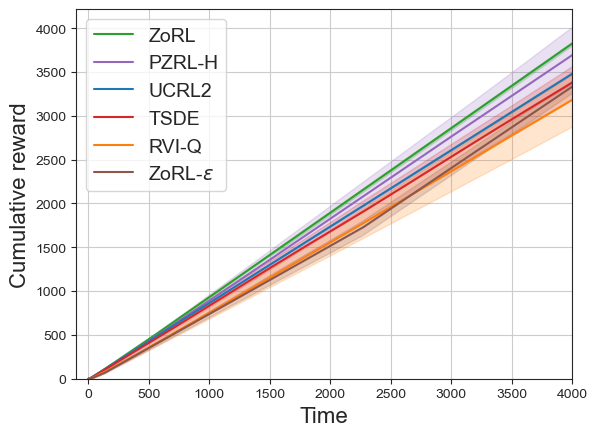

In [26]:
reward_mean_2, reward_std_2 = {}, {}
for expt in expts:
    reward_mean_2[expt] = np.mean(rewards_2[expt],axis=0)
    reward_std_2[expt] = np.std(rewards_2[expt],axis=0)
np.save('RiverSwim_data.npy', [reward_mean_2, reward_std_2])

plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),reward_mean_2[expt], color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),reward_mean_2[expt]-reward_std_2[expt],
                     reward_mean_2[expt]+reward_std_2[expt], color=colors[expt],alpha=0.2)
    plt.legend(fontsize=14,loc='best')
plt.grid()
plt.xlabel('Time',fontsize=16)
plt.ylabel('Cumulative reward',fontsize=16)
plt.xlim(-100,T)
plt.ylim(0)
plt.savefig("RiverSwim_cumul_reward.pdf")

In [27]:
def gain(env, T):
    seed = 0
    np.random.seed(seed)
    sum_rewards = 0
    cumul_rewards = []
    next_state = env.init()
    for t in range(T):
        _, reward = env.step(np.ones(1))
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
    return sum_rewards/T
optimal_gain = gain(M,100000)
optimal_performance = optimal_gain*np.arange(1,T+1)

In [28]:
for i in range(repeats):
    for expt in expts:
        regrets_2[expt][i] = optimal_performance - rewards_2[expt][i]

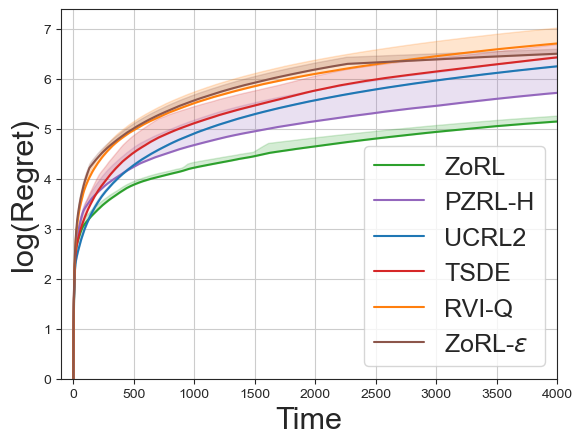

In [29]:
plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),np.log(np.mean(regrets_2[expt],axis=0)), color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),np.log(np.mean(regrets_2[expt],axis=0)),
                     np.log(np.mean(regrets_2[expt],axis=0)+np.std(regrets_2[expt],axis=0)), color=colors[expt],alpha=0.2)
    plt.legend(fontsize=18,loc=4)
plt.grid()
plt.xlabel('Time',fontsize=22)
plt.ylabel('log(Regret)',fontsize=22)
plt.xlim(-100,T)
plt.ylim(0)
plt.savefig("RiverSwim_logRegret.pdf")

Environment: Linear System of with m=4, n=2

In [30]:
M = LinSys2x4()
d_S = M.d_S
d_A = M.d_A
d = d_S + d_A
T = 4000

### Hyperparameters ###

## ZoRL, ZoRL-eps ##
C_a = 0.1
L_r = 0.001
C_c = 1
C_H = 1e-3
eps_bd = 1

zorl_hps = [C_a, L_r, C_c, C_H, eps_bd]

C_a = 1
L_r = 0.001
C_c = 5
C_H = 1e-1
eps_bd = 1
zorl_e_hps = [C_a, L_r, C_c, C_H, eps_bd]

## PZRL ##
model = nn.Sequential(
            nn.Linear(M.d_S, M.d_A)
)

pzrl_hps = [C_a, L_r, C_c, eps_bd]

eps = 0.25

In [31]:
repeats = 50
rewards_4 = {}
for expt in expts:
    rewards_4[expt] = np.zeros((repeats, T))

In [32]:
verbose = False
for run in range(repeats):
    print("Run: ", run+1, end='\r', flush=True)
    for expt in expts:
        start = time.time()
        if expt == 'ucrl2':
            rewards_4[expt][run] = ucrl2(M, T, eps, C_c, run, verbose)
        elif expt == 'zorl':
            rewards_4[expt][run] = zorl(M, T, zorl_hps, run, verbose)
        elif expt == 'zorl-e':
            rewards_4[expt][run] = zorl_eps(M, T, zorl_e_hps, run, verbose)
        elif expt == 'rvi_q':
            rewards_4[expt][run] = rvi_q(M, T, eps, run, verbose)
        elif expt == 'tsde':
            rewards_4[expt][run] = tsde(M, T, eps, run, verbose)
        elif expt == 'pzrl':
            rewards_4[expt][run] = pzrl(M, T, pzrl_hps, model, run, verbose)

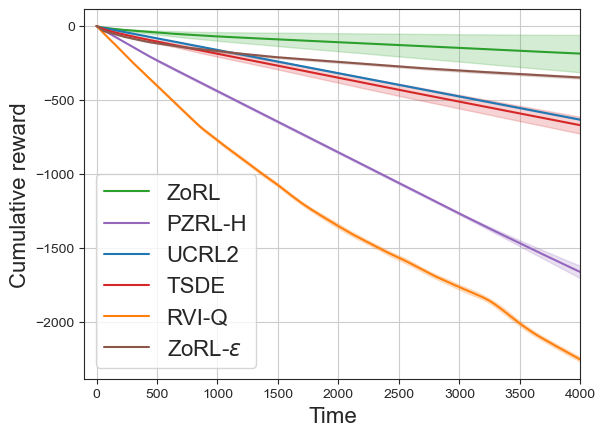

In [33]:
reward_mean_4, reward_std_4 = {}, {}
for expt in expts:
    reward_mean_4[expt] = np.mean(rewards_4[expt],axis=0)
    reward_std_4[expt] = np.std(rewards_4[expt],axis=0)
np.save('LinSys2x4_data.npy', [reward_mean_4, reward_std_4])

plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),reward_mean_4[expt], color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),reward_mean_4[expt]-reward_std_4[expt],
                     reward_mean_4[expt]+reward_std_4[expt], color=colors[expt],alpha=0.2)
    plt.legend(fontsize=16,loc='best')
plt.grid()
plt.xlabel('Time',fontsize=16)
plt.ylabel('Cumulative reward',fontsize=16)
plt.xlim(-100,T)
plt.savefig("LinSys2x4_cumul_reward.pdf")

Environment: Non-linear System

In [34]:
M = NonLinSys2x2()
d_S = M.d_S
d_A = M.d_A
d = d_S + d_A
T = 4000

### Hyperparameters ###

## ZoRL, ZoRL-eps ##
C_a = 0.5
L_r = 0.001
C_c = 5
C_H = 0.1
eps_bd = 1

zorl_hps = [C_a, L_r, C_c, C_H, eps_bd]

C_a = 1
L_r = 0.001
C_c = 5
C_H = 0.1
eps_bd = 1
zorl_e_hps = [C_a, L_r, C_c, C_H, eps_bd]

## PZRL ##
model = nn.Sequential(
    nn.Linear(M.d_S, 4),
    nn.ReLU(),
    nn.Linear(4, M.d_A)
)

pzrl_hps = [C_a, L_r, C_c, eps_bd]

eps = 0.25

In [35]:
repeats = 50
rewards_5 = {}
for expt in expts:
    rewards_5[expt] = np.zeros((repeats, T))

In [36]:
verbose = False
for run in range(repeats):
    print("Run: ", run+1, end='\r', flush=True)
    for expt in expts:
        start = time.time()
        if expt == 'ucrl2':
            rewards_5[expt][run] = ucrl2(M, T, eps, C_c, run, verbose)
        elif expt == 'zorl':
            rewards_5[expt][run] = zorl(M, T, zorl_hps, run, verbose)
        elif expt == 'zorl-e':
            rewards_5[expt][run] = zorl_eps(M, T, zorl_e_hps, run, verbose)
        elif expt == 'rvi_q':
            rewards_5[expt][run] = rvi_q(M, T, eps, run, verbose)
        elif expt == 'tsde':
            rewards_5[expt][run] = tsde(M, T, eps, run, verbose)
        elif expt == 'pzrl':
            rewards_5[expt][run] = pzrl(M, T, pzrl_hps, model, run, verbose)

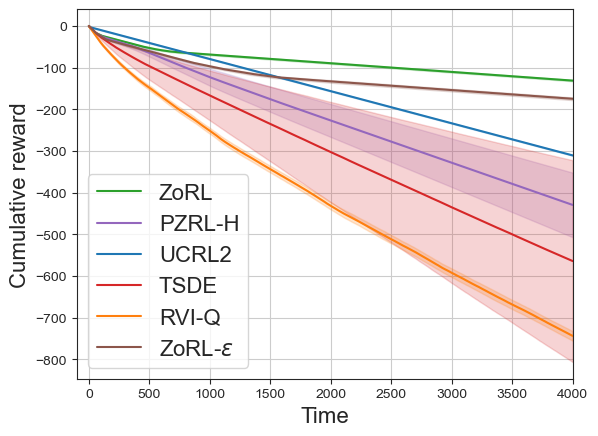

In [37]:
reward_mean_5, reward_std_5 = {}, {}
for expt in expts:
    reward_mean_5[expt] = np.mean(rewards_5[expt],axis=0)
    reward_std_5[expt] = np.std(rewards_5[expt],axis=0)
np.save('NonLinSys_data.npy', [reward_mean_5, reward_std_5])

plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),reward_mean_5[expt], color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),reward_mean_5[expt]-reward_std_5[expt],
                     reward_mean_5[expt]+reward_std_5[expt], color=colors[expt],alpha=0.2)
    plt.legend(fontsize=16,loc='best')
plt.grid()
plt.xlabel('Time',fontsize=16)
plt.ylabel('Cumulative reward',fontsize=16)
plt.xlim(-100,T)
#plt.ylim(100)
plt.savefig("NonLinSys_cumul_reward.pdf")